<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

#  Библиотеки

In [6]:
!pip install -q ydata-profiling
!pip install -q optuna
!pip install -q --upgrade catboost
!pip install -q lightgbm
!pip install -q --upgrade xgboost
!pip install -q matplotlib==3.7.3
!pip install -q --upgrade scikit-learn
!pip install -q --upgrade Pillow

In [7]:
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
from scipy import stats as st
from scipy.special import erfinv


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import plotly.express as px

from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from ydata_profiling import ProfileReport

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from optuna import create_study
from optuna import Study
from optuna import trial

In [8]:
print(pd.__version__)

2.2.2


In [9]:
RANDOM_STATE = 42

sns.set(rc={'figure.figsize':(15,4)})

def lineplot(data, title):
    data.plot()
    plt.title(title)
    plt.show()

## Подготовка

In [10]:
try:
    df = pd.read_csv(r"C:\Users\Aleksandr\Downloads\taxi\taxi.csv", index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
    
print(f'Shape data is {df.shape}')

Shape data is (26496, 1)


In [11]:
profile_df = ProfileReport(df, title="Profiling Report")
profile_df

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- **Пропусков в данных нет**
- **67 строк дубликатов, после переиндексации будет меньше**

In [12]:
df.index.is_monotonic_increasing

True

In [13]:
df = df.resample('1H').sum()
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [14]:
# df.duplicated().sum()
# df.drop_duplicates(inplace=True)

In [15]:
print(f'Shape data is {df.shape}')

Shape data is (4416, 1)


## Анализ

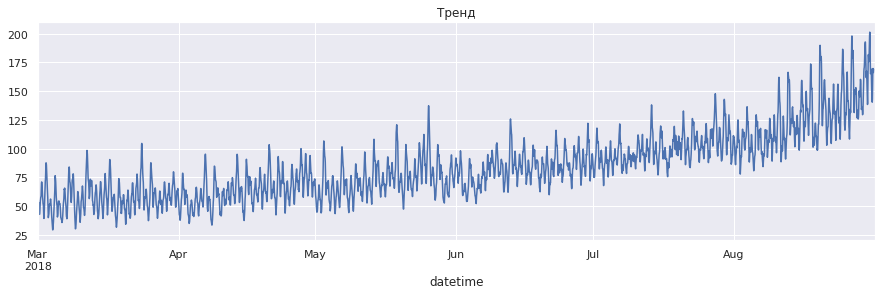

In [16]:
decomposed = seasonal_decompose(df, model='additive', period=12)
lineplot(decomposed.trend, 'Тренд')

- **тред растет к летним периодам, пора отпусков, прогулко после которых надо добираться до дома**
- **скорость треда, так же плавно увеличиваеться**
- **это добавит интервалы доверия с вероятностью 95% к графику тренда**

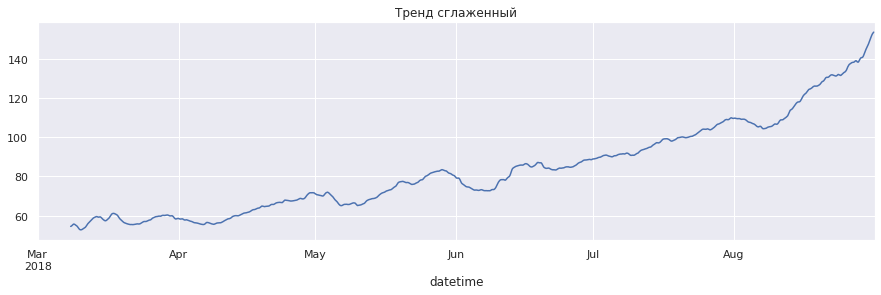

In [17]:
lineplot(decomposed.trend.shift().rolling(24*7).mean(), 'Тренд сглаженный')

<div class="alert alert-block alert-warning">
<b>Изменения_1:</b> Добавил shift()
</div>  

- **тренд повышения к летним месяцам**

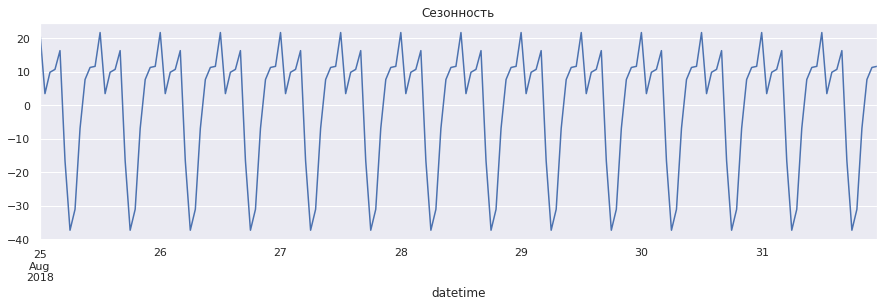

In [18]:
lineplot(decomposed.seasonal.tail(24*7), 'Сезонность')

- **повторяющиеся узоры каждые 30 дней (кроме первых двух месяцев, все улетели и отдыхают)**
- **странные узоры на (2018-04,2018-05) и (2018-07, 2018-08)**
- **рост по сезонности начинается в начале месяца, с характерными пиками и в конце месяца**
- **спады ночью, рост днем**

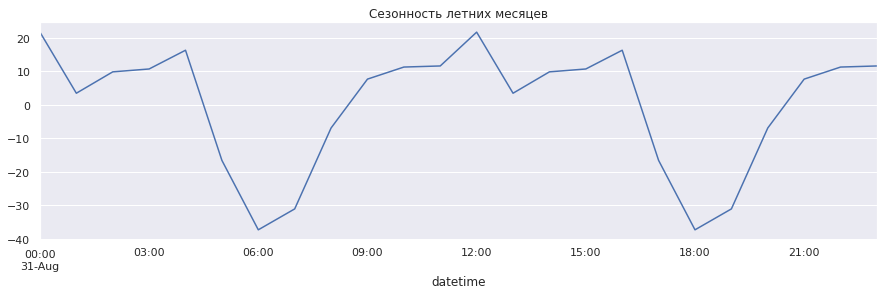

In [19]:
df_summer = decomposed.seasonal.loc[decomposed.seasonal.index.month.isin([6, 7, 8])]
df_summer_weekly = df_summer.tail(24)
lineplot(df_summer_weekly, 'Сезонность летних месяцев')

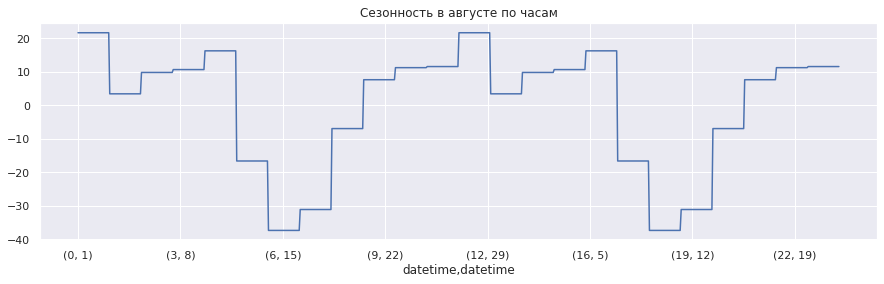

In [20]:
df_aug = decomposed.seasonal.loc[(decomposed.seasonal.index.month == 8)]
df_aug_hourly = df_aug.groupby([df_aug.index.hour, df_aug.index.day]).mean()
lineplot(df_aug_hourly, 'Сезонность в августе по часам')

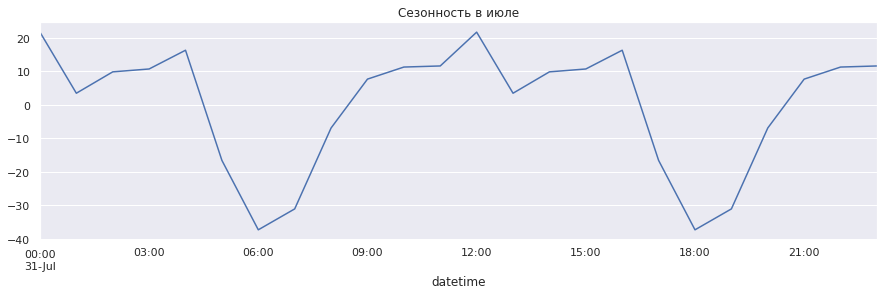

In [21]:
lineplot(decomposed.seasonal.loc[(decomposed.seasonal.index.month == 7)].tail(24), 'Сезонность в июле')

 1. **Август стабилизация спроса**
 2. **Спад ночью, рост с утра и днем, пик к вечеру**


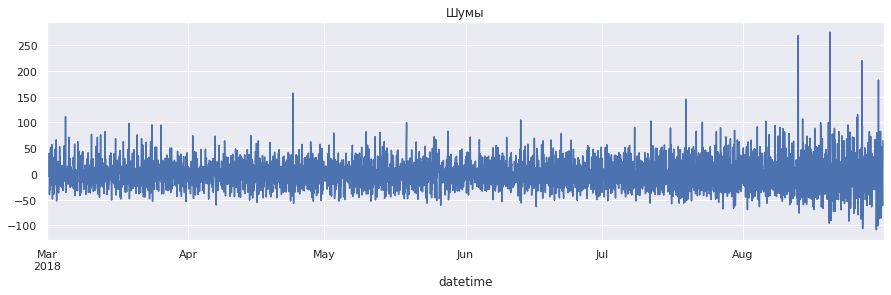

In [22]:
lineplot(decomposed.resid.shift(), 'Шумы')

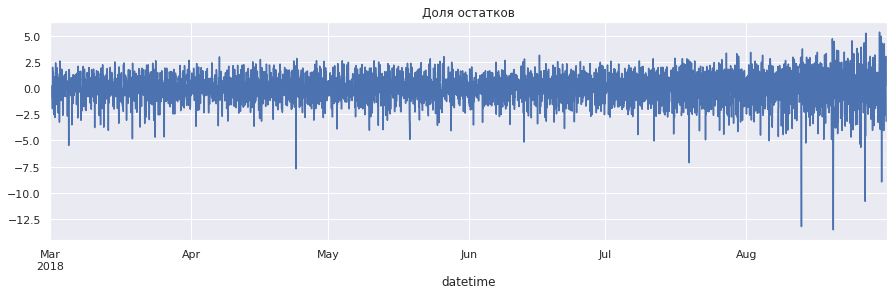

In [23]:
lineplot(decomposed.resid / decomposed.resid.sum(), 'Доля остатков')

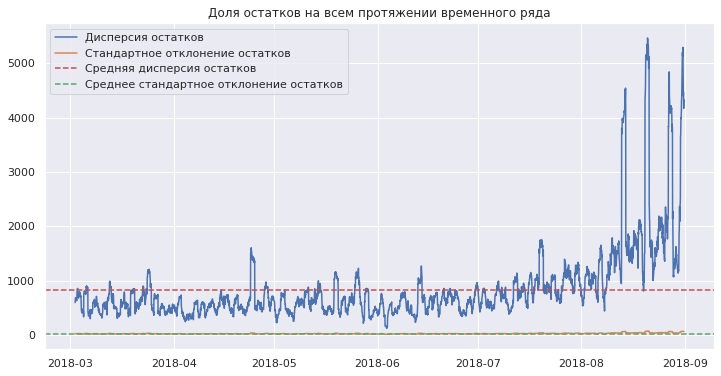

In [24]:
resid_var = decomposed.resid.var()
resid_std = decomposed.resid.std()

plt.figure(figsize=(12, 6))
plt.plot(decomposed.resid.rolling(window=30).var(), label='Дисперсия остатков')
plt.plot(decomposed.resid.rolling(window=30).std(), label='Стандартное отклонение остатков')
plt.axhline(y=resid_var, color='r', linestyle='--', label='Средняя дисперсия остатков')
plt.axhline(y=resid_std, color='g', linestyle='--', label='Среднее стандартное отклонение остатков')
plt.legend()
plt.title('Доля остатков на всем протяжении временного ряда')
plt.show()

**1. Стандартное отклонение остатков говорит нам о том, что  в тестовую выборку попадет чуть больше данных, которые сложно объяснить и на которых модели будет сложнее предсказывать.**  

In [25]:
ts = df['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


## Обучение

In [26]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    
    return data

In [27]:
df_copy = make_features(df,24,24)
df_copy.shape

(4392, 29)

In [28]:
df_copy = df_copy.reset_index(drop=True)

**когда делаю reset_index, метрика возростает**

In [29]:
X_train, X_val_test, y_train, y_val_test = train_test_split(df_copy.drop(['num_orders'], axis=1),
                                                            df_copy['num_orders'], 
                                                            test_size=0.2,
                                                            shuffle = False,
                                                            random_state=RANDOM_STATE)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5,
                                                shuffle = False, random_state=RANDOM_STATE)

**CatBoostRegressor**

In [30]:
def optimize_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 2, 13),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
         'random_strength': trial.suggest_loguniform('random_strength', 1e-9, 10.0),  
         'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),  
         'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 1e-2, 10.0),  
         'border_count': trial.suggest_int('border_count', 32, 255),  
         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),  
    }
    model = CatBoostRegressor(**params, verbose = 0)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return rmse

study_catboost = create_study(direction='minimize')
study_catboost.optimize(optimize_catboost, n_trials=40)

best_params_catboost = study_catboost.best_params
best_params_catboost

[I 2024-09-19 16:59:05,488] A new study created in memory with name: no-name-004d3b56-e35e-4fbc-80f3-3060e99418d8
[I 2024-09-19 17:01:37,549] Trial 0 finished with value: 52.297564057185376 and parameters: {'iterations': 434, 'depth': 13, 'learning_rate': 0.0006433982297384845, 'l2_leaf_reg': 0.0033004372518576843, 'random_strength': 0.009880355030299007, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.3474806495184162, 'border_count': 191, 'min_data_in_leaf': 39}. Best is trial 0 with value: 52.297564057185376.
[I 2024-09-19 17:01:44,631] Trial 1 finished with value: 47.043876483781965 and parameters: {'iterations': 447, 'depth': 9, 'learning_rate': 0.001347817470883124, 'l2_leaf_reg': 0.0710252515225804, 'random_strength': 3.181385566531355e-06, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.2637958729519959, 'border_count': 91, 'min_data_in_leaf': 21}. Best is trial 1 with value: 47.043876483781965.
[I 2024-09-19 17:01:45,700] Trial 2 finished with value: 51.090

{'iterations': 362,
 'depth': 8,
 'learning_rate': 0.06116993038147407,
 'l2_leaf_reg': 0.02197734375868594,
 'random_strength': 2.455018169700545e-09,
 'leaf_estimation_iterations': 4,
 'bagging_temperature': 0.013901654404905386,
 'border_count': 40,
 'min_data_in_leaf': 2}

**XGBRegressor**

In [31]:
def optimize_xgboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 13),
         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
         'subsample': trial.suggest_float('subsample', 0.1, 1.0),
         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
    }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return rmse

study_xgboost = create_study(direction='minimize')
study_xgboost.optimize(optimize_xgboost, n_trials=40)

best_params_xgboost = study_xgboost.best_params
best_params_xgboost

[I 2024-09-19 17:05:51,332] A new study created in memory with name: no-name-eb59f85d-4494-4511-b548-6bb8ded2c234
[I 2024-09-19 17:05:52,136] Trial 0 finished with value: 33.85329126898994 and parameters: {'n_estimators': 328, 'learning_rate': 0.29718829551028003, 'max_depth': 5, 'gamma': 0.000243615510041602, 'subsample': 0.7284269277606524, 'colsample_bytree': 0.9379264690825919}. Best is trial 0 with value: 33.85329126898994.
[I 2024-09-19 17:05:52,352] Trial 1 finished with value: 38.92693525631766 and parameters: {'n_estimators': 315, 'learning_rate': 0.011906729923321131, 'max_depth': 3, 'gamma': 5.807729745574176e-08, 'subsample': 0.6523303478954174, 'colsample_bytree': 0.17560866115316334}. Best is trial 0 with value: 33.85329126898994.
[I 2024-09-19 17:05:54,793] Trial 2 finished with value: 34.51262213871711 and parameters: {'n_estimators': 294, 'learning_rate': 0.07043258708698573, 'max_depth': 11, 'gamma': 7.597296164985333e-08, 'subsample': 0.2708691634309599, 'colsample_b

{'n_estimators': 497,
 'learning_rate': 0.01981031049448124,
 'max_depth': 6,
 'gamma': 5.1761031988887906e-05,
 'subsample': 0.9696285844842629,
 'colsample_bytree': 0.8626024017232863}

**LGBMRegressor**

In [32]:
def optimize_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 13),
         'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = LGBMRegressor(**params, verbose = -1)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return rmse

study_lgbm = create_study(direction='minimize')
study_lgbm.optimize(optimize_lgbm, n_trials=40)

best_params_lgbm = study_lgbm.best_params
best_params_lgbm

[I 2024-09-19 17:07:15,046] A new study created in memory with name: no-name-99320373-ba0f-4267-96ce-dd5027fb5f64
[I 2024-09-19 17:07:21,510] Trial 0 finished with value: 32.91860557539593 and parameters: {'n_estimators': 202, 'learning_rate': 0.2604552110900391, 'max_depth': 3, 'num_leaves': 832, 'min_child_samples': 19}. Best is trial 0 with value: 32.91860557539593.
[I 2024-09-19 17:07:28,016] Trial 1 finished with value: 31.643302385514684 and parameters: {'n_estimators': 408, 'learning_rate': 0.021649506962665325, 'max_depth': 8, 'num_leaves': 582, 'min_child_samples': 30}. Best is trial 1 with value: 31.643302385514684.
[I 2024-09-19 17:07:30,208] Trial 2 finished with value: 32.26164071440803 and parameters: {'n_estimators': 393, 'learning_rate': 0.32702835847286016, 'max_depth': 3, 'num_leaves': 425, 'min_child_samples': 95}. Best is trial 1 with value: 31.643302385514684.
[I 2024-09-19 17:07:31,311] Trial 3 finished with value: 32.337977138322714 and parameters: {'n_estimators

{'n_estimators': 373,
 'learning_rate': 0.027447716437707038,
 'max_depth': 11,
 'num_leaves': 648,
 'min_child_samples': 12}

**RandomForestRegressor**

In [33]:
def optimize_randomforest(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 13),
         'max_features': trial.suggest_float('max_features', 0.1, 1.0),
         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return rmse

study_randomforest = create_study(direction='minimize')
study_randomforest.optimize(optimize_randomforest, n_trials=40)

best_params_randomforest = study_randomforest.best_params
best_params_randomforest

[I 2024-09-19 17:14:11,015] A new study created in memory with name: no-name-e2a569d1-2525-495d-a675-95669c6d37cb
[I 2024-09-19 17:14:14,257] Trial 0 finished with value: 36.5460054477251 and parameters: {'n_estimators': 407, 'max_depth': 6, 'max_features': 0.34459589959327674, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 36.5460054477251.
[I 2024-09-19 17:14:14,709] Trial 1 finished with value: 45.16641419949459 and parameters: {'n_estimators': 94, 'max_depth': 2, 'max_features': 0.6281837211453434, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 0 with value: 36.5460054477251.
[I 2024-09-19 17:14:18,291] Trial 2 finished with value: 42.03709411324827 and parameters: {'n_estimators': 468, 'max_depth': 3, 'max_features': 0.7037273658661194, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 0 with value: 36.5460054477251.
[I 2024-09-19 17:14:21,725] Trial 3 finished with value: 32.71899252057006 and parameters: {'n_estimators': 94

{'n_estimators': 441,
 'max_depth': 12,
 'max_features': 0.7939077956030814,
 'min_samples_split': 3,
 'min_samples_leaf': 1}

**CatBoostRegressor**

In [34]:
best_model_catboost = CatBoostRegressor(**best_params_catboost, verbose = 0)
best_model_catboost.fit(X_train, y_train)
best_pred_catboost = best_model_catboost.predict(X_val)
best_rmse_catboost = np.sqrt(mean_squared_error(y_val, best_pred_catboost))
best_rmse_catboost

30.731416743479066

**XGBRegressor**

In [35]:
best_model_xgboost = XGBRegressor(**best_params_xgboost)
best_model_xgboost.fit(X_train, y_train)
best_pred_xgboost = best_model_xgboost.predict(X_val)
best_rmse_xgboost = np.sqrt(mean_squared_error(y_val, best_pred_xgboost))
best_rmse_xgboost

31.260894578815464

**LGBMRegressor**

In [36]:
best_model_lgbm = LGBMRegressor(**best_params_lgbm,verbose = -1)
best_model_lgbm.fit(X_train, y_train)
best_pred_lgbm = best_model_lgbm.predict(X_val)
best_rmse_lgbm = np.sqrt(mean_squared_error(y_val, best_pred_lgbm))
best_rmse_lgbm

31.106721376639214

**RandomForestRegressor**

In [37]:
best_model_randomforest = RandomForestRegressor(**best_params_randomforest)
best_model_randomforest.fit(X_train, y_train)
best_pred_randomforest = best_model_randomforest.predict(X_val)
best_rmse_randomforest = np.sqrt(mean_squared_error(y_val, best_pred_randomforest))
best_rmse_randomforest

32.50992108823591

**Сравнение результатов**

In [38]:
results_df = pd.DataFrame({
    'Модель': ['CatBoost', 'XGBoost', 'LGBM', 'RandomForest'],
    'RMSE': [best_rmse_catboost, best_rmse_xgboost, best_rmse_lgbm, best_rmse_randomforest]
})
print(results_df)

         Модель       RMSE
0      CatBoost  30.731417
1       XGBoost  31.260895
2          LGBM  31.106721
3  RandomForest  32.509921


In [39]:
estimators = [
    ('cat', CatBoostRegressor(**best_params_catboost, verbose = 0)),
    ('xgb', XGBRegressor(**best_params_xgboost),
    ('lgbm', LGBMRegressor(**best_params_lgbm,verbose = -1)),
    ('rf', RandomForestRegressor(**best_params_randomforest)))
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)
reg.fit(X_train, y_train)
best_pred_reg = reg.predict(X_val)
best_rmse_reg = np.sqrt(mean_squared_error(y_val, best_pred_reg))
best_rmse_reg

29.67151921670792

## Тестирование

In [40]:
# best_model_catboost = CatBoostRegressor(**best_params_catboost, random_state=RANDOM_STATE, verbose = 0)
# best_model_catboost.fit(X_train, y_train)
# best_pred_catboost = best_model_catboost.predict(X_test)
# best_rmse_catboost = np.sqrt(mean_squared_error(y_test, best_pred_catboost))
# best_rmse_catboost

estimators = [
    ('cat', CatBoostRegressor(**best_params_catboost, verbose = 0)),
    ('xgb', XGBRegressor(**best_params_xgboost),
    ('lgbm', LGBMRegressor(**best_params_lgbm,verbose = -1)),
    ('rf', RandomForestRegressor(**best_params_randomforest)))
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)
reg.fit(X_train, y_train)
best_pred_reg = reg.predict(X_test)
best_rmse_reg = np.sqrt(mean_squared_error(y_test, best_pred_reg))
best_rmse_reg

47.31293319485075

**Значение метрики RMSE на тестовой выборке должно быть не больше 48. Условие выполнено!**

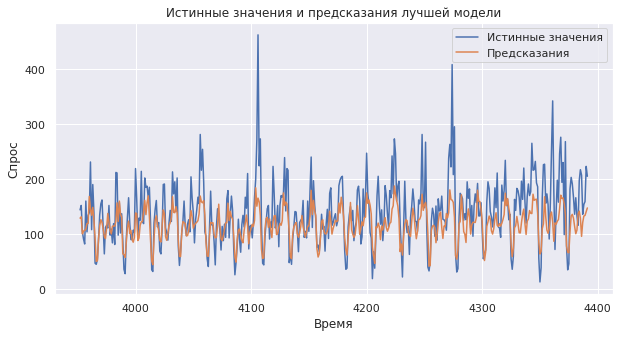

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))

y_test_df = pd.DataFrame(y_test)
y_test_df.index = X_test.index

ax.plot(y_test_df, label='Истинные значения')
ax.plot(y_test_df.index, best_pred_reg, label='Предсказания')

ax.set_xlabel('Время')
ax.set_ylabel('Спрос')
ax.set_title('Истинные значения и предсказания лучшей модели')
ax.legend()

plt.show()

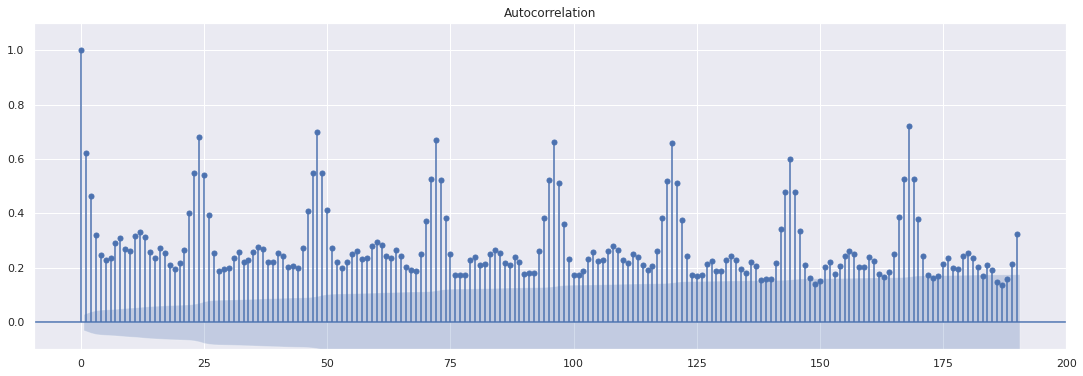

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48